In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
import cv2
from scipy import ndimage
import random
from tqdm import tqdm
import shutil
import statistics

/deep/u/tanvid/anaconda3/envs/newenv/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        #color = np.array([251/255, 252/255, 30/255, 0.8])
        color = np.array([255, 255, 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

def show_points(coords, ax, marker_size=100):
    pos_points = coords
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

def medsam_inference_auto(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=None,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    print(low_res_pred)
    low_res_pred = low_res_pred.squeeze().cpu().detach().numpy()  # (256, 256)
    print(np.max(low_res_pred))
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

def medsam_inference_point(medsam_model, img_embed, x_1, y_1, x_2, y_2, H, W):
    coords_1024 = np.array([[x_1 * 1024 / W, y_1 * 1024 / H], [x_2 * 1024 / W, y_2 * 1024 / H]])
    #
    #coords_1024_2 = np.array([[[
    #        x_2 * 1024 / W,
    #        y_2 * 1024 / H
    #    ]]])
    coords_torch = torch.tensor([coords_1024], dtype=torch.float32).to(img_embed.device)
    labels_torch = torch.tensor([[1, -1]], dtype=torch.long).to(img_embed.device)
    point_prompt = (coords_torch, labels_torch)
    
    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=point_prompt,
        boxes=None,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.detach().cpu().numpy().squeeze()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

In [5]:
# load MedSAM model
MedSAM_CKPT_PATH = "work_dir/MedSAM/medsam_vit_b.pth"

# use the following for point prompts
#MedSAM_CKPT_PATH = "work_dir/MedSAM/medsam_point_prompt_flare22.pth"

device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU()
        )
      )
      (1): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (n

In [6]:
%cd ..

/sailhome/tanvid/Auto-Generate-WLs/generate-weak-labels


In [7]:
def make_mask_bbox(directory_path, prediction_path, save_path, filename):
    
    img_np = io.imread(os.path.join(directory_path, filename))
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    H, W, _ = img_3c.shape
    
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

    
    # using the 50-image model prediction, dynamically threshold the map using thresholds of 70%, 65%, or 40%.
    image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 120, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 168, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 100, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 50, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 25, 0, 1)

    if image_mask.sum() == 0:
        print(filename)
        return
    
    # find the bounding box using the min/max row/column in the thresholded map
    labeled_array, num_features = ndimage.label(image_mask)
    component_sizes = np.bincount(labeled_array.ravel())
    largest_component_label = np.argmax(component_sizes[1:]) + 1
    indices = np.argwhere(labeled_array == largest_component_label)

    row_indices = indices[:, 0]
    col_indices = indices[:, 1]    
    bbox = [min(col_indices), min(row_indices), max(col_indices), max(row_indices)]
    bbox2 = [0, 0, 0, 0]
    bbox2[1] = bbox[1] * (H/image_mask.shape[0])
    bbox2[0] = bbox[0] * (W/image_mask.shape[1])
    bbox2[3] = bbox[3] * (H/image_mask.shape[0])
    bbox2[2] = bbox[2] * (W/image_mask.shape[1])


    box_np = np.array(np.round([bbox2]))
    # transfer box_np to 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)
    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(img_3c)
    ax[0].set_title("Input Image and Bounding Box")
    ax[1].imshow(img_3c)
    show_mask(medsam_seg, ax[1])
    show_box(box_np[0], ax[1])
    ax[1].set_title("MedSAM Segmentation")
    ax[2].imshow(image_mask)
    show_box(np.array(bbox), ax[2])
    plt.show()


    binary_array = medsam_seg.astype(np.uint8) * 255
    percent_target = binary_array.sum() / (binary_array.shape[0] * binary_array.shape[1]*255) 
    output_path = os.path.join(save_path, filename.replace("_mask.png", ".png").replace('.jpg', '.png'))
    plt.imsave(output_path, binary_array, cmap='gray')
    

In [8]:
def make_mask_points(directory_path, prediction_path, save_path, filename):
    
    # read in the original image from the directory path and preprocess according to medSAM requirements
    #filename = filename.replace('.jpg', '.png')
    img_np = io.imread(os.path.join(directory_path, filename))
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    H, W, _ = img_3c.shape
    
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

    
    # using the 50-image model prediction, dynamically threshold the map.
    image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 225, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 168, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 100, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 50, 0, 1)
    if image_mask.sum() == 0:
        image_mask = np.where(cv2.imread(os.path.join(prediction_path, filename.replace('.jpg', '.png')),  cv2.IMREAD_GRAYSCALE) < 25, 0, 1)

    if image_mask.sum() == 0:
        return
    
    false_indices = np.argwhere(~image_mask)
    random_false_index = list(random.choice(false_indices))

    

    
    labeled_array, num_features = ndimage.label(image_mask)
    component_sizes = np.bincount(labeled_array.ravel())
    largest_component_label = np.argmax(component_sizes[1:]) + 1
    
    indices = np.argwhere(labeled_array == largest_component_label)
    row_indices = indices[:, 0]
    col_indices = indices[:, 1] 
    
    # uncomment if using second-largest component as well
    #second_largest_label = np.argsort(component_sizes[1:])[-2] + 1
    #indices2 = np.argwhere(labeled_array == second_largest_label)
    #row_indices2 = indices2[:, 0]
    #col_indices2 = indices2[:, 1] 
    #point3 = [statistics.median(col_indices2), statistics.median(row_indices2)]
    #point4 = [0, 0]
    #point4[1] = point3[1] * (H/image_mask.shape[0])
    #point4[0] = point3[0] * (W/image_mask.shape[1])
    
    point = [statistics.median(col_indices), statistics.median(row_indices)]
    point2 = [0, 0]
    point2[1] = point[1] * (H/image_mask.shape[0])
    point2[0] = point[0] * (W/image_mask.shape[1])

    false_point = [0, 0]
    false_point[1] = random_false_index[1] * (H/image_mask.shape[0])
    false_point[0] = random_false_index[0] * (W/image_mask.shape[1])

    



    box_np = np.array(np.round([point2]))
    box_np_2 = np.array(np.round([false_point]))
    #box_np_3 = np.array(np.round([point4]))


    # transfer box_np t0 1024x1024 scale
    box_1024 = box_np / np.array([W, H]) * 1024
    #box_1024_2 = box_np_3 / np.array([W, H]) * 1024

    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)
    medsam_seg = medsam_inference_point(medsam_model, image_embedding, box_np[0][0], box_np[0][1], box_np_2[0][0], box_np_2[0][1], H, W)

    fig, ax = plt.subplots(1, 3, figsize=(10, 5))
    ax[0].imshow(img_1024)
    show_points(box_1024, ax[0])
    #s#how_points(box_1024_2, ax[0])

    ax[0].set_title("Input Image and Bounding Box")
    ax[1].imshow(img_3c)
    show_mask(medsam_seg, ax[1])
    show_points(box_np, ax[1])
    ax[1].set_title("MedSAM Segmentation")
    ax[2].imshow(image_mask)
    show_points(np.array([point]), ax[2])
    plt.show()


    binary_array = medsam_seg.astype(np.uint8) * 255
    output_path = os.path.join(save_path, filename.replace("_mask.png", ".png").replace('.jpg', '.png'))
    plt.imsave(output_path, binary_array, cmap='gray')


  0%|          | 0/75 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


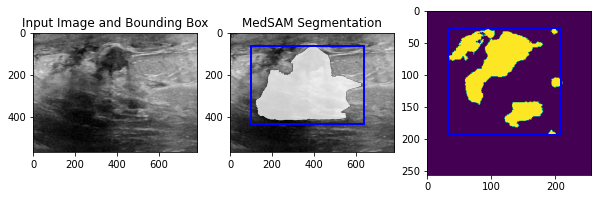

  1%|▏         | 1/75 [00:01<01:58,  1.60s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


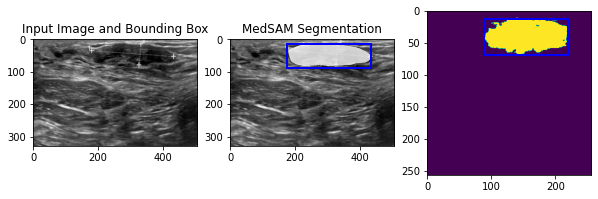

  3%|▎         | 2/75 [00:02<01:20,  1.10s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


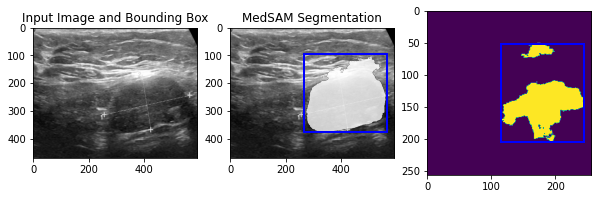

  4%|▍         | 3/75 [00:03<01:09,  1.04it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


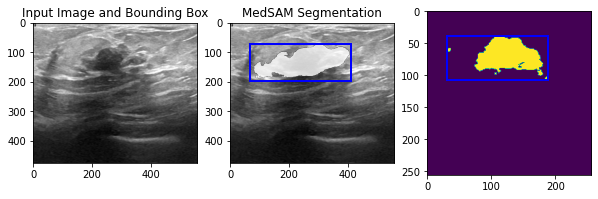

  5%|▌         | 4/75 [00:03<01:03,  1.12it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


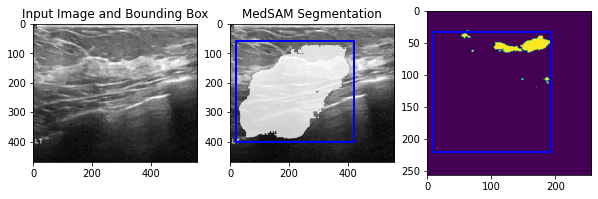

  7%|▋         | 5/75 [00:04<00:58,  1.19it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


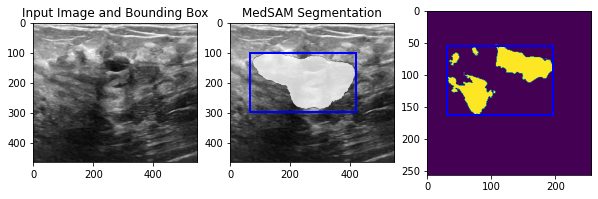

  8%|▊         | 6/75 [00:05<00:53,  1.28it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


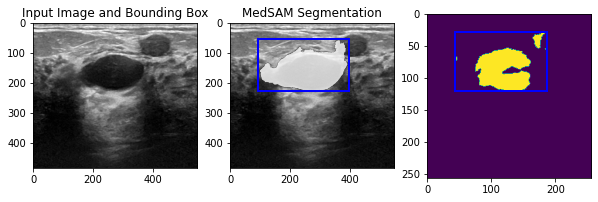

  9%|▉         | 7/75 [00:06<00:50,  1.34it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


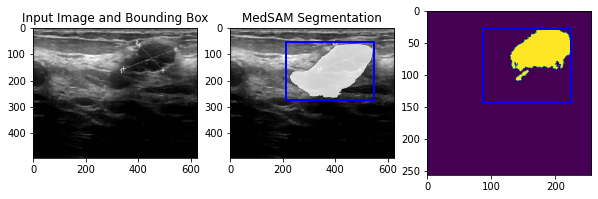

 11%|█         | 8/75 [00:06<00:58,  1.15it/s]


KeyboardInterrupt: 

In [12]:
base_path = "../pytorch-nested-unet"

# aug_path: path of the unlabeled dataset
aug_path = "busi-25-aug-50"
# base_dataset: path of the gold-standard dataset
base_dataset = "busi-25-small"

image_path = os.path.join(base_path, "inputs", aug_path, "images")
save_path = os.path.join(base_path, "inputs", aug_path, "masks/0")

# formatted like ../pytorch-nested-unet/outputs/<model name>/<unlabeled dataset name>/0/"
prediction_path = "../pytorch-nested-unet/outputs/busi-25-small_NestedUNet_256_woDS/busi-25-aug-50/0/"

masks_to_gen = os.listdir(os.path.join(base_path, "inputs", aug_path, "images"))

for filename in tqdm(masks_to_gen):
    if os.path.isfile(os.path.join(image_path, filename)):
        # replace with make_mask_points if using point prompts
        make_mask_bbox(image_path, prediction_path, save_path, filename)
        
# copy over base dataset to form augmented dataset
base_images = os.listdir(os.path.join(base_path, "inputs", base_dataset, "images"))
base_masks = os.listdir(os.path.join(base_path, "inputs", base_dataset, "masks/0"))

for filename in base_images:
    shutil.copyfile(os.path.join(base_path, "inputs", base_dataset, "images", filename), os.path.join(image_path, filename))

for filename in base_masks:
    shutil.copyfile(os.path.join(base_path, "inputs", base_dataset, "masks/0", filename), os.path.join(save_path, filename))
